#Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ctypes
from time import time

In [24]:
def UnaryCode(n):
    return n + 1

def TruncatedBinaryCode(n, m):
    b = int(np.ceil(np.log(m + 0.) / np.log(2.0)))
    small = (n < (2 ** b - m))
    return (b - 1) * small + b * (1 - small)

def GolombCompress(data, m):
    res = np.sum(UnaryCode(data / m)) + np.sum(TruncatedBinaryCode(data % m, m))
    return res

In [25]:
def Generate():
    filenames = []
    for i in (0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.5, 0.7):
        data = np.random.geometric(i, 1000000)
        filename = str(int(1000 * i))
        filenames.append(filename)
        with open(filename, 'w') as outputfile:
            for el in data:
                outputfile.write(str(el) + '\n')
    return filenames

In [26]:
def SaveCompCoeffs(filenames):
    compcoeffs = np.zeros((len(filenames), 512), dtype=np.float64)
    thetime = time()
    for i in xrange(len(filenames)):
        data = []
        j = 0
        with open(filenames[i], 'r') as inputfile:
            for line in inputfile:
                j += 1
                if len(line) == 0:
                    break
                n = int(line.strip())
                data.append(n)
                #if (j+1) % 200000 == 0:
                #    print i, j
        print i, "data size is", len(data), time() - thetime
        original_size = len(data) * ctypes.sizeof(ctypes.c_int) * 8
        data = np.array(data)
        for m in xrange(512):
            coded_size = GolombCompress(data, m + 1)
            #if m % 100 == 0:
            #    print m, time() - thetime
            compcoeffs[i][m] = (original_size + 0.) / coded_size   
    return compcoeffs

In [56]:
thetime = time()
filenames = Generate()
print time() - thetime

136.622800827


In [135]:
thetime = time()
compcoeffs = SaveCompCoeffs(filenames)
print time() - thetime

0 data size is 1000000 2.08464479446
1 data size is 1000000 50.6396329403
2 data size is 1000000 98.9426949024
3 data size is 1000000 147.121159792
4 data size is 1000000 195.237345934
5 data size is 1000000 243.329365969
6 data size is 1000000 291.517242908
7 data size is 1000000 339.65118289
8 data size is 1000000 387.710277796
433.805727959


In [174]:
totalcoeffs = np.ravel(np.dot(np.ones((1,9), dtype=np.float64), compcoeffs))
m_opt = np.argmax(totalcoeffs)

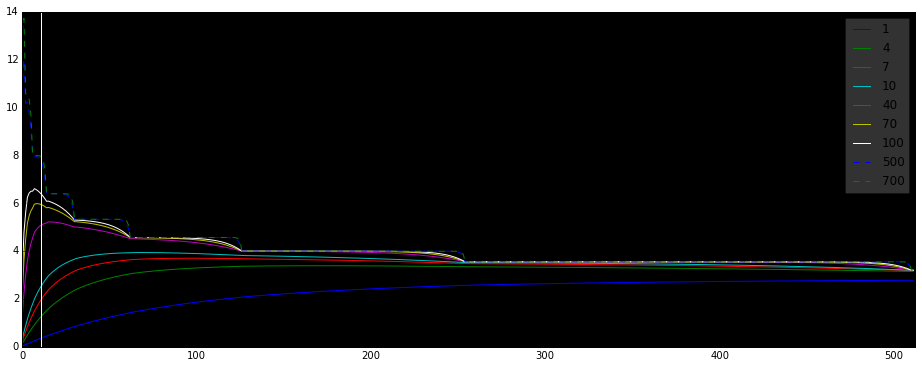

In [200]:
fig = plt.figure(figsize=(16,6))
colors = ('b','g','r','c','m','y','w','b','g')
styles = ('-','-','-','-','-','-','-','--','--')
axes = fig.add_subplot(1, 1, 1, axisbg='black')
for i in xrange(9):
    plt.plot(compcoeffs[i, :], c=colors[i], ls=styles[i], label = filenames[i])
xlim = plt.xlim([0,512])
plt.axvline(x=m_opt, ymin=0, ymax=14, color = 'white')
plt.legend(framealpha=0.2)

#Optimal m for the whole dataset

In [15]:
def loadLists(filename):
    """Load index from a file, returns dict key = word number
    value = list of (document number, count of word in the document)"""
    index = []
    i = 0
    with open(filename, 'r') as index_file:
        for line in index_file:
            linelist = line.strip().split()[1:]
            current_list = []
            for j in range(0, len(linelist)):
                current_pair = linelist[j].strip().split(':')
                for k in xrange(int(current_pair[1])):
                    current_list.append(int(current_pair[0]))
            index.append(sorted(current_list))
    return index

In [16]:
thetime = time()
index = loadLists('index.txt')
print time() - thetime

152.738889933


In [20]:
# compressing
thetime = time()
compressed_index = []
empties = []
for i in xrange(len(index)):
    if len(index[i]) > 0:
        curr_line = np.zeros((len(index[i]),), dtype=int)
        curr_line[0] = index[i][0]
        for j in xrange(1, len(index[i])):
            curr_line[j] = index[i][j] - index[i][j-1]
        compressed_index.append(curr_line)
    else:
        empties.append(i)
print - thetime + time()

163.407105923


In [21]:
len(empties)

0

In [22]:
thetime = time()
full_sizes = np.zeros((len(compressed_index)), dtype=int)
for i in xrange(len(compressed_index)):
    full_sizes[i] =  len(compressed_index[i]) * ctypes.sizeof(ctypes.c_int) * 8
print time() - thetime

5.95628094673


In [30]:
thetime = time()
comp_sum_coeffs_first = np.zeros((16))
for i in xrange(len(compressed_index)):
    if i % 100000 == 0:
        print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], 2 ** m)
        comp_sum_coeffs_first[m] += coded_size   
print time() - thetime

 0 0.000473022460938
100000 232.780017853
200000 412.631098986
300000 586.193538904
400000 750.765649796
500000 916.741621971
600000 1080.27258301
700000 1242.88011098
800000 1404.77126884
900000 1566.22916484
1000000 1728.21289396
1100000 1889.77484083
1200000 2050.89742994
1300000 2211.91710496
1400000 2373.30659485
1500000 2534.467278
1600000 2695.15574384
1700000 2855.76425886
1800000 3015.88867593
1900000 3176.26072192
2000000 3337.16189599
2100000 3497.59314299
2200000 3658.06178093
2300000 3818.593081
2400000 3979.25420499
2500000 4139.73069787
2600000 4300.2100749
2700000 4460.93477702
4480.02224588


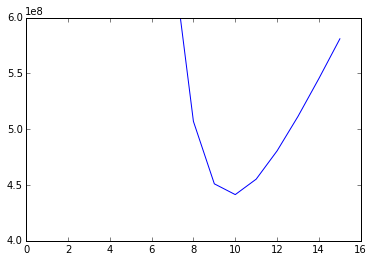

In [37]:
plt.plot(comp_sum_coeffs_first)
lim = plt.ylim([0.4 * 10 ** 9, 0.6 * 10**9])

In [34]:
m_min_first = 2 ** (np.argmin(comp_sum_coeffs_first) - 1)
m_max_first = 2 ** (np.argmin(comp_sum_coeffs_first) + 1)

In [38]:
thetime = time()
comp_sum_coeffs_second = np.zeros((12))
for i in xrange(len(compressed_index)):
    if i % 100000 == 0:
        print i, time() - thetime
    for m in xrange(12):
        coded_size = GolombCompress(compressed_index[i], m_min_first + 2 ** m)
        comp_sum_coeffs_second[m] += coded_size   
print time() - thetime

0 0.000558853149414
100000 188.303677797
200000 337.213680983
300000 485.657042027
400000 628.90760088
500000 772.1386199
600000 914.74593401
700000 1056.92890286
800000 1199.11974692
900000 1341.0599308
1000000 1482.56648684
1100000 1623.67847681
1200000 1764.95726299
1300000 1906.74206281
1400000 2048.338552
1500000 2189.70409298
1600000 2331.33164692
1700000 2472.87922883
1800000 2614.03930497
1900000 2755.33933592
2000000 2896.88154888
2100000 3038.29006195
2200000 3179.5822258
2300000 3320.80736494
2400000 3462.69082999
2500000 3603.74128485
2600000 3744.80190897
2700000 3886.01772285
3902.93905687


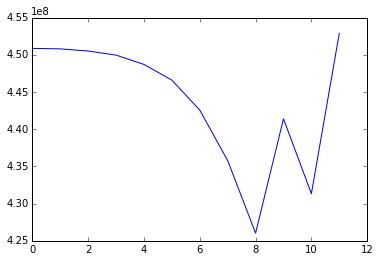

In [39]:
plt.plot(comp_sum_coeffs_second)
#lim = plt.ylim([0, 0.1 * 10**10])

In [53]:
m_min_second = m_min_first + 2 ** 7
m_max_second = 2 ** 11

In [56]:
thetime = time()
comp_sum_coeffs_third = np.zeros((16))
for i in xrange(len(compressed_index)):
    if i % 100000 == 0:
        print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], m_min_second + m * (m_max_second - m_min_second) / 15)
        comp_sum_coeffs_third[m] += coded_size   
print time() - thetime

0 0.000550985336304
100000 222.261101007
200000 418.86855197
300000 615.204613924
400000 805.240943909
500000 996.095495939
600000 1185.91530704
700000 1375.89889407
800000 1565.50414801
900000 1754.96956801
1000000 1944.37163401
1100000 2133.72645402
1200000 2323.75755906
1300000 2512.91898394
1400000 2703.69023013
1500000 2894.47461295
1600000 3083.42074513
1700000 3272.32157111
1800000 3460.8273201
1900000 3649.41945601
2000000 3837.86747098
2100000 4026.81729507
2200000 4215.571033
2300000 4404.55735898
2400000 4593.05482793
2500000 4781.76416397
2600000 4970.28992105
2700000 5159.11483312
5181.64864802


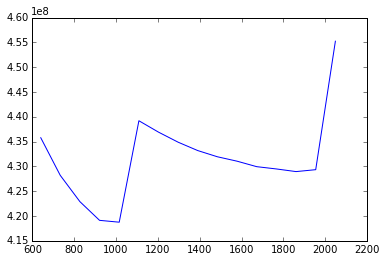

In [59]:
ms = m_min_second + np.array(range(16)) * (m_max_second - m_min_second) / 15
plt.plot(ms, comp_sum_coeffs_third)
#lim = plt.ylim([3.035 * 10 ** 8, 3.06 * 10**8])

In [61]:
m_min_third = m_min_second + (np.argmin(comp_sum_coeffs_third) - 1) * (m_max_second - m_min_second) / 15
m_max_third = m_min_second + (np.argmin(comp_sum_coeffs_third) + 1) * (m_max_second - m_min_second) / 15

In [ ]:
thetime = time()
comp_sum_coeffs_last = np.zeros(16)
for i in xrange(len(compressed_index)):
    if i % 100000 == 0:
        print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], m_min_third + m * (m_max_third - m_min_third) / 15)
        comp_sum_coeffs_last[m] += coded_size   
print time() - thetime

0 0.00051212310791
100000 219.531186104
200000 415.446947098
300000 610.532803059
400000 800.09092021
500000 989.746539116
600000 1178.9044342
700000 1368.33082604
800000 1557.40374422
900000 1746.06961608
1000000 1934.45389009
1100000 2122.77984214
1200000 2311.43941617
1300000 2499.71346402
1400000 2688.32511115
1500000 2876.16455221
1600000 3064.33326721
1700000 3252.27282715
1800000 3440.43858099
1900000 3628.43402719
2000000 3816.49271417
2100000 4004.5330801
2200000 4192.566046
2300000 4380.12986422
2400000 4568.03098011
2500000

In [ ]:
ms = m_min_third + np.array(range(16)) * (m_max_third - m_min_third) / 15
plt.plot(ms, comp_sum_coeffs_last)
#lim = plt.ylim([3.035 * 10**8, 3.04 * 10**8])

In [ ]:
thetime = time()
comp_sum_coeffs_total = np.zeros(16)
for i in xrange(len(compressed_index)):
    if i % 100000 == 0:
        print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], m_min_third + m * (m_max_third - m_min_third) / 15)
        comp_sum_coeffs_total[m] += coded_size   
print time() - thetime

In [ ]:
opt_big_index_m = m_min_third + np.argmin(comp_sum_coeffs_last)

In [147]:
print 'opt m ', opt_big_index_m

opt m  250


#Longest list

In [118]:
l = np.argmax(full_sizes)
print 'max list: ', l, compressed_index[l].shape[0]

 max list:  175968 435178


In [78]:
l_comp_coeffs = np.zeros((512))
for m in xrange(512):
    l_comp_coeffs[m] = GolombCompress(compressed_index[l], m + 1)
m_opt = np.argmin(l_comp_coeffs) + 1
print 'optimal m: ', m_opt

optimal m:  1


In [79]:
p_t = (compressed_index[l].shape[0] + 0.) / (compressed_index[l].shape[0] + np.sum(compressed_index[l]))
print 'theoretical p: ', p_t

theoretical p:  0.94409962143


In [80]:
def Vurhis(p):
    for m in xrange(2 ** 15):
        if p ** (m + 1) + p ** (m + 2) <= 1 and 1 < p ** (m + 1) + p ** m:
            return m+1#, p, p ** (m + 1) + p ** (m + 2),  p ** (m + 1) + p ** m
    return 2 ** 15

In [83]:
print 'theoretical m: ', Vurhis(p_t)

 theoretical m:  12
